# 8-3 covid19 데이터 분석
http://itpaper.co.kr/demo/covid19/all.php 페이지를 통해

    1. JSON데이터를 수집
    2. 그 결과를 지역별 딕셔너리로 구성
    3. 집계결과를 생성
    4. 각종 시각화 지표 만들기
    
# #01. 필요한 패키지 가져오기

In [1]:
import requests
import json
import datetime as dt
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot
from IPython.display import SVG
from bs4 import BeautifulSoup

# #02. 데이터 수집하기
## 1) HTTP 세션 준비

In [2]:
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36"
session= requests.Session()
session.headers.update({'User-agent':user_agent, 'referer':None})

## 2) 접근 URL 정의

In [3]:
api_url = "http://itpaper.co.kr/demo/covid19/all.php"

## 3) JSON 데이터 가져오기

In [4]:
# 데이터 가져오기
r = session.get(api_url)

# 결과 검사
if r.status_code != 200:
    print("[%d Error] %s" % (r.status_code, r.reason))
    quit()
    
r.encoding = 'utf-8'
covid19_dict = json.loads(r.text)

covid19_dict

{'collection_datetime': '2021-03-04 12:00:02',
 'data': {'서울': {'date': ['20200217',
    '20200218',
    '20200219',
    '20200220',
    '20200221',
    '20200222',
    '20200223',
    '20200224',
    '20200225',
    '20200226',
    '20200227',
    '20200228',
    '20200229',
    '20200301',
    '20200302',
    '20200303',
    '20200304',
    '20200305',
    '20200306',
    '20200307',
    '20200308',
    '20200309',
    '20200310',
    '20200311',
    '20200312',
    '20200313',
    '20200314',
    '20200315',
    '20200316',
    '20200317',
    '20200318',
    '20200319',
    '20200320',
    '20200321',
    '20200322',
    '20200323',
    '20200324',
    '20200325',
    '20200326',
    '20200327',
    '20200328',
    '20200329',
    '20200330',
    '20200331',
    '20200401',
    '20200402',
    '20200403',
    '20200404',
    '20200405',
    '20200406',
    '20200407',
    '20200408',
    '20200409',
    '20200410',
    '20200411',
    '20200412',
    '20200413',
    '20200414',
   

# #03. 데이터 전처리
지역별로 데이터프레임을 생성해야 하지만, 전국에 대한 데이터프레임을 일일이 만들기 = 비효율적<br>
따라서 각 지역별 데이터프레임에 `지역` 컬럼 추가 후 통합 데이터 프레임에 병합

--> 최종적으로 하나의 데이터프레임으로 분석을 수행할 수 있도록 데이터 전처리

## 1) 수집한 데이터에서 지역명(key) 가져오기

In [5]:
지역명 = list(covid19_dict['data'].keys())
지역명

['서울',
 '부산',
 '대구',
 '인천',
 '광주',
 '대전',
 '울산',
 '세종',
 '경기',
 '강원',
 '충북',
 '충남',
 '전북',
 '전남',
 '경북',
 '경남',
 '제주']

## 2) DataFrame 재구성

In [6]:
데이터누적 = DataFrame()

for v in 지역명:
    # 하나의 지역을 임시 데이터프레임으로 변환
    tmp_df = DataFrame(covid19_dict['data'][v])
    
    # 임시 데이터 프레임에 지역명 컬럼 추가
    tmp_df['지역'] = v
    
    # 임시 데이터 프레임을 누적해서 병합
    데이터누적 = 데이터누적.append(tmp_df)
    
# 컬럼이름 변경을 위한 딕셔너리 정의
column_name = {'date':'날짜', 'active':'치료중', 'confirmed_acc':'누적확진자', 'death_acc':'누적사망자', 'released_acc':'누적격리해제',
              'confirmed':'확진자', 'death':'사망자', 'released':'격리해제'}
데이터누적.rename(columns=column_name, inplace=True)

# 데이터 병합과정에서 중복되는 index가 발생하므로 index 번호를 리셋한다
# -> drop=True는 기존의 인덱스를 삭제하는 옵션
데이터누적.reset_index(drop=True, inplace=True)

데이터누적

,날짜,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제,지역
0,20200217,11,14,0,3,14,0,3,서울
1,20200218,11,14,0,3,0,0,0,서울
2,20200219,10,15,0,5,1,0,2,서울
3,20200220,17,22,0,5,7,0,0,서울
4,20200221,21,27,0,6,5,0,1,서울
...,...,...,...,...,...,...,...,...,...
6489,20210228,31,570,1,538,1,0,0,제주
6490,20210301,26,570,1,543,0,0,5,제주
6491,20210302,29,575,1,545,5,0,2,제주
6492,20210303,33,579,1,545,4,0,0,제주


## 3) 날짜 타입 처리
수집한 데이터는 날짜 형식이 문자열로 지정되어 있다. 이를 datetime 형식으로 변경하기 위해 `yyyy-mm-dd` 형식 문자열로 치환한다.

In [7]:
covid19_df = 데이터누적.copy()
# infer_datetime_format=True는 파이썬이 문자열의 날짜형식을 지능적으로 판단하여 format 추측
covid19_df['날짜'] = pd.to_datetime(covid19_df['날짜'], infer_datetime_format=True)
covid19_df['날짜']

0      2020-02-17
1      2020-02-18
2      2020-02-19
3      2020-02-20
4      2020-02-21
          ...    
6489   2021-02-28
6490   2021-03-01
6491   2021-03-02
6492   2021-03-03
6493   2021-03-04
Name: 날짜, Length: 6494, dtype: datetime64[ns]

# #04. 전국 누적 확진자 현황
## 1) 데이터프레임에서 가장 큰 날짜값 추출
원 데이터에 누적 확진자 정보가 포함되어 있기 때문에 가장 마지막 날짜에 대한 누적 확진자 값을 구하면 된다.

In [8]:
last_date = covid19_df['날짜'].max()
last_date

Timestamp('2021-03-04 00:00:00')

## 2) 마지막 날짜에 해당하는 데이터만 추출

In [9]:
# last_df = covid19_df[(covid19_df['날짜'] == last_date)]
last_df = covid19_df.query('날짜 == @last_date')
last_df

,날짜,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제,지역
381,2021-03-04,2884,28691,388,25419,118,3,168,서울
763,2021-03-04,232,3282,108,2942,18,0,15,부산
1145,2021-03-04,138,8673,214,8321,20,0,5,대구
1527,2021-03-04,238,4494,53,4203,18,1,26,인천
1909,2021-03-04,125,2105,21,1959,6,0,3,광주
2291,2021-03-04,29,1196,15,1152,3,0,5,대전
2673,2021-03-04,23,1016,37,956,0,0,1,울산
3055,2021-03-04,22,236,1,213,0,0,0,세종
3437,2021-03-04,2277,24242,496,21469,186,2,132,경기
3819,2021-03-04,98,1883,41,1744,6,0,15,강원


## 3) 데이터 프레임의 각 컬럼별 합계 산정

In [10]:
전국합계 = last_df.sum()
전국합계

치료중                                     6788
누적확진자                                  88248
누적사망자                                   1615
누적격리해제                                 79845
확진자                                      418
사망자                                        7
격리해제                                     460
지역        서울부산대구인천광주대전울산세종경기강원충북충남전북전남경북경남제주
dtype: object

## 4) 데이터프레임으로 병합

In [11]:
전국합계df = DataFrame(전국합계, columns=[last_date.strftime('%m/%d')])
전국합계df.drop('지역', inplace=True)
전국합계df

,03/04
치료중,6788
누적확진자,88248
누적사망자,1615
누적격리해제,79845
확진자,418
사망자,7
격리해제,460


# #05. 날짜별 추세
## 1) 날짜별로 전국 합산 산출

In [12]:
날짜별df = covid19_df.filter(['날짜', '치료중', '누적확진자', '누적사망자', '누적격리해제', '확진자', '사망자', '격리해제']).groupby('날짜').sum()
날짜별df

,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제
날짜,,,,,,,
2020-02-17,20,30,0,10,30,0,10
2020-02-18,19,31,0,12,1,0,2
2020-02-19,35,51,0,16,20,0,4
2020-02-20,91,108,1,16,57,1,0
2020-02-21,187,205,1,17,97,0,1
...,...,...,...,...,...,...,...
2021-02-28,6722,86703,1599,78382,346,7,364
2021-03-01,6697,87053,1601,78755,350,2,373
2021-03-02,6763,87388,1602,79023,335,1,268


## 2) 최근 일주일 데이터 조회
### 검색 범위를 지정하기 위해 일주일 전의 날짜 얻기

In [13]:
delta = dt.timedelta(days=-7)
day7 = dt.datetime.now()+delta
day7

datetime.datetime(2021, 2, 25, 12, 13, 0, 107143)

### 일주일 전 날짜 이후의 데이터 조회

In [14]:
일주일검색df = 날짜별df[(날짜별df.index>=day7)]
일주일검색df

,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제
날짜,,,,,,,
2021-02-26,6760,85945,1582,77603,380,4,393
2021-02-27,6747,86357,1592,78018,412,10,415
2021-02-28,6722,86703,1599,78382,346,7,364
2021-03-01,6697,87053,1601,78755,350,2,373
2021-03-02,6763,87388,1602,79023,335,1,268
2021-03-03,6837,87830,1608,79385,442,6,362
2021-03-04,6788,88248,1615,79845,418,7,460


## 3) 일일 및 누적 확진환자 추세
### 그래프 기본 설정

In [15]:
# 그래프를 만들기 위한 한글 폰트 설정
pyplot.rcParams['font.family'] = 'Malgun Gothic'
pyplot.rcParams['font.size'] = 16
pyplot.rcParams['figure.figsize'] = (20, 10)

### 하나의 그래프에서 y축이 두 개인 형태의 서브플롯 생성

[0, 1, 2, 3, 4, 5, 6]
['02/26', '02/27', '02/28', '03/01', '03/02', '03/03', '03/04']


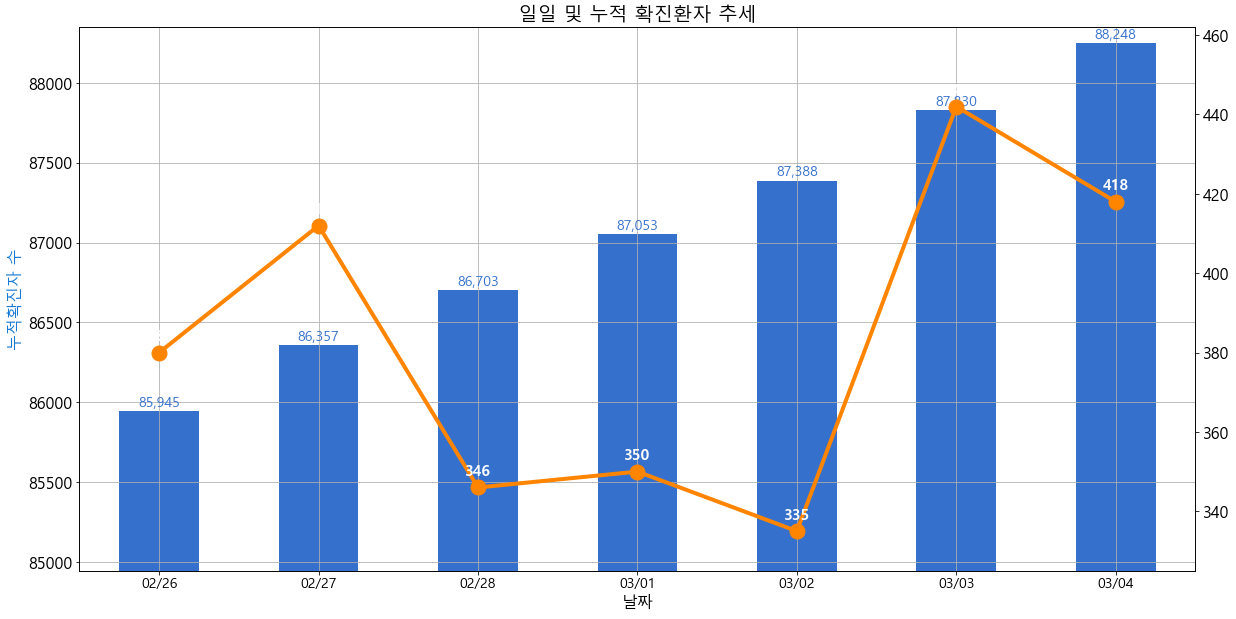

In [18]:
fig = pyplot.figure()       # 그래프 시작
ax1=fig.add_subplot(1,1,1)  # 1행 1열로 구성된 서브플롯 생성
ax2=ax1.twinx()             # ax1에 겹쳐지는 서브플롯 생성

pyplot.title('일일 및 누적 확진환자 추세')


#----------------------------------------------------
# 누적 확진 (막대 그래프)
#----------------------------------------------------
일주일검색df['누적확진자'].plot.bar(ax=ax1, color='#3571cc', rot=0)

ax1.set_xlabel('날짜')
ax1.set_ylabel('누적확진자 수', color='#1779d4')
ax1.grid()
ax1.set_ylim([일주일검색df['누적확진자'].min()-1000, 일주일검색df['누적확진자'].max()+100])

# 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['누적확진자']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax1.text(i, v+10, msg, fontsize=14, color="#3571cc",
            horizontalalignment='center', verticalalignment='bottom')
    
# x축 표시 라벨 설정
k = list(range(0, len(일주일검색df)))
print(k)
ax1.set_xticks(k)

# x축 라벨에 표시할 텍스트
x_labels=[]

for date in 일주일검색df.index:
    x_labels.append(date.strftime("%m/%d"))
print(x_labels)

ax1.set_xticklabels(x_labels, fontsize=14, color='#000000')

#----------------------------------------------------
# 일별 확진 (시계열 그래프)
#----------------------------------------------------
x = list(range(0, len(일주일검색df)))
y = 일주일검색df['확진자']
ax2.plot(x, y, color='#ff8400', marker='o', linewidth=4, markersize=15)

ax2.set_ylim([일주일검색df['확진자'].min()-10, 일주일검색df['확진자'].max()+20])

# 시계열 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['확진자']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax2.text(i, v+2, msg, fontsize=15, color="#ffffff",
            horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
pyplot.show()

## 3) 확진환자 내 일일 및 누적 격리해제 추세

[0, 1, 2, 3, 4, 5, 6]
['02/26', '02/27', '02/28', '03/01', '03/02', '03/03', '03/04']


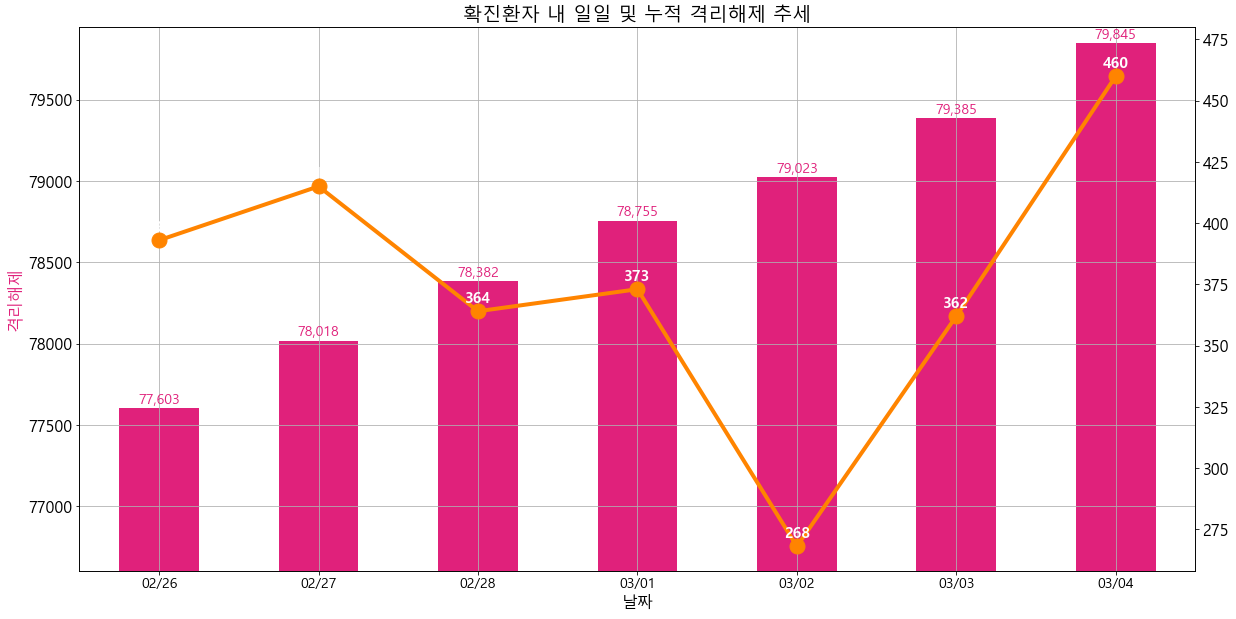

In [19]:
fig = pyplot.figure()       # 그래프 시작
ax1=fig.add_subplot(1,1,1)  # 1행 1열로 구성된 서브플롯 생성
ax2=ax1.twinx()             # ax1에 겹쳐지는 서브플롯 생성

pyplot.title('확진환자 내 일일 및 누적 격리해제 추세')


#----------------------------------------------------
# 누적 확진 (막대 그래프)
#----------------------------------------------------
일주일검색df['누적격리해제'].plot.bar(ax=ax1, color='#E0217B', rot=0)

ax1.set_xlabel('날짜')
ax1.set_ylabel('격리해제', color='#E0217B')
ax1.grid()
ax1.set_ylim([일주일검색df['누적격리해제'].min()-1000, 일주일검색df['누적격리해제'].max()+100])

# 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['누적격리해제']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax1.text(i, v+10, msg, fontsize=14, color="#E0217B",
            horizontalalignment='center', verticalalignment='bottom')
    
# x축 표시 라벨 설정
k = list(range(0, len(일주일검색df)))
print(k)
ax1.set_xticks(k)

# x축 라벨에 표시할 텍스트
x_labels=[]

for date in 일주일검색df.index:
    x_labels.append(date.strftime("%m/%d"))
print(x_labels)

ax1.set_xticklabels(x_labels, fontsize=14, color='#000000')

#----------------------------------------------------
# 일별 확진 (시계열 그래프)
#----------------------------------------------------
x = list(range(0, len(일주일검색df)))
y = 일주일검색df['격리해제']
ax2.plot(x, y, color='#ff8400', marker='o', linewidth=4, markersize=15)

ax2.set_ylim([일주일검색df['격리해제'].min()-10, 일주일검색df['격리해제'].max()+20])

# 시계열 그래프 위에 텍스트 표시
for i, v in enumerate(일주일검색df['격리해제']):
    # 세자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax2.text(i, v+2, msg, fontsize=15, color="#ffffff",
            horizontalalignment='center', verticalalignment='bottom', fontweight='bold')
    
pyplot.show()

# #06. 시도별 발생동향
## 1) 시도별 누적 확진자
마지막 날짜에 해당하는 row만 추출하여 <b>누적확진자</b> 컬럼을 `filter()` 함수로 처리한다.

In [20]:
last_date = covid19_df['날짜'].max()
지역별누적확진자df = covid19_df[(covid19_df['날짜'] == last_date)]
지역별누적확진자df

,날짜,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제,지역
381,2021-03-04,2884,28691,388,25419,118,3,168,서울
763,2021-03-04,232,3282,108,2942,18,0,15,부산
1145,2021-03-04,138,8673,214,8321,20,0,5,대구
1527,2021-03-04,238,4494,53,4203,18,1,26,인천
1909,2021-03-04,125,2105,21,1959,6,0,3,광주
2291,2021-03-04,29,1196,15,1152,3,0,5,대전
2673,2021-03-04,23,1016,37,956,0,0,1,울산
3055,2021-03-04,22,236,1,213,0,0,0,세종
3437,2021-03-04,2277,24242,496,21469,186,2,132,경기
3819,2021-03-04,98,1883,41,1744,6,0,15,강원


## 2) 지역별 확진환자 빈도 그래프 (막대그래프)
### 누적 확진 확자 기준으로 정렬

In [21]:
정렬df = 지역별누적확진자df.sort_values('누적확진자')
정렬df

,날짜,치료중,누적확진자,누적사망자,누적격리해제,확진자,사망자,격리해제,지역
3055,2021-03-04,22,236,1,213,0,0,0,세종
6493,2021-03-04,34,582,1,547,3,0,2,제주
5347,2021-03-04,84,872,8,780,1,0,7,전남
2673,2021-03-04,23,1016,37,956,0,0,1,울산
2291,2021-03-04,29,1196,15,1152,3,0,5,대전
4965,2021-03-04,110,1221,55,1056,6,0,8,전북
4201,2021-03-04,130,1801,58,1613,12,0,18,충북
3819,2021-03-04,98,1883,41,1744,6,0,15,강원
1909,2021-03-04,125,2105,21,1959,6,0,3,광주
6111,2021-03-04,67,2208,13,2128,10,1,3,경남


### 시각화에 적합한 형태로 전처리를 위한 컬럼 추출
가로막대그래프의 경우<br>
<b>y축</b> = 데이터프레임의 인덱스, <b>x축</b> = 각각의 값 이기 때문에 <br>
지역명을 인덱스로 하고 누적확진자 컬럼을 값으로 가지는 형태의 전처리 필요

In [22]:
지역별누적확진자df = 정렬df.filter(['지역', '누적확진자'])
지역별누적확진자df

,지역,누적확진자
3055,세종,236
6493,제주,582
5347,전남,872
2673,울산,1016
2291,대전,1196
4965,전북,1221
4201,충북,1801
3819,강원,1883
1909,광주,2105
6111,경남,2208


### 인덱스 컬럼 설정하기

In [23]:
결과df = 지역별누적확진자df.set_index('지역')
결과df

,누적확진자
지역,
세종,236
제주,582
전남,872
울산,1016
대전,1196
전북,1221
충북,1801
강원,1883
광주,2105


### 시각화

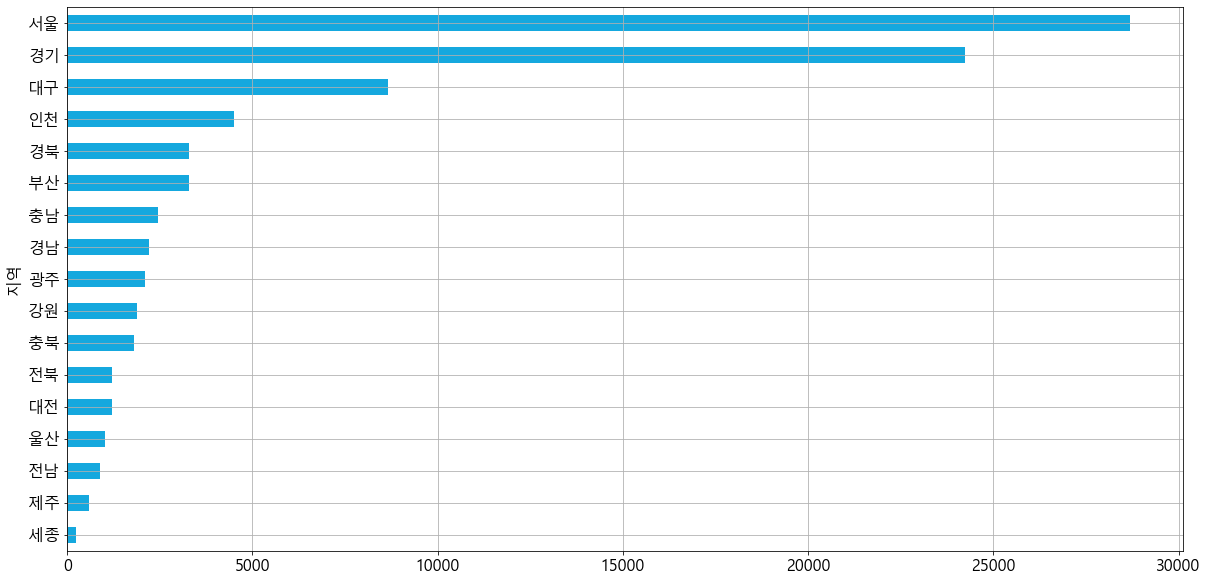

In [24]:
결과df.plot.barh(color='#15A8DE', legend=None)
pyplot.grid()

# 그래프 위에 텍스트 표시
for i,v in enumerate(결과df['누적확진자']):
    # 세 자리마다 콤마를 표시하는 형식 지정
    msg = '{n:,}'.format(n=v)
    ax1.text(v+20, i, msg, fontsize=14, color="#15A8DE",
            horizontalalignment='left', verticalalignment='center')
    
pyplot.show()

## 3) 지역별 누적 확진자 지도 시각화
### svg 맵 가져오기

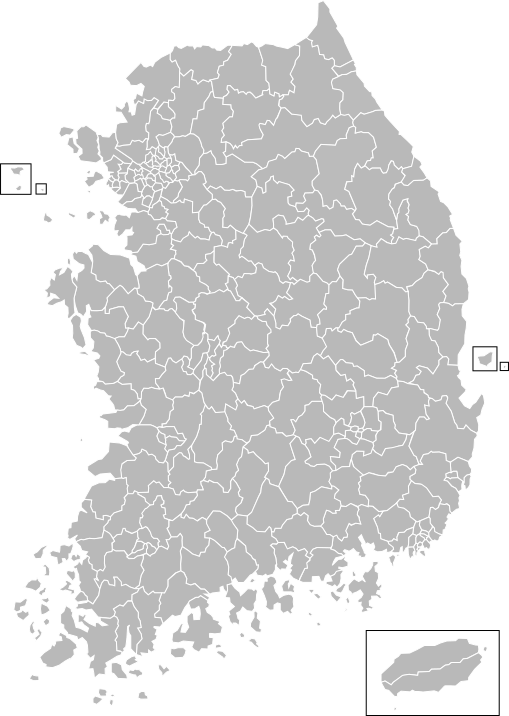

In [25]:
map_svg = None
with open('./map_korea.svg', 'r', encoding='utf-8') as f:
    map_svg = f.read()

SVG(map_svg)

### 지도에 적용할 단계명 색상 리스트

In [31]:
# 사용할 색상값 (단계별 5개 색상 준비)
colors = ['#F1EEF6', '#D4B9DA', '#C994C7', '#DF65B9', '#DD1C77']

### 데이터 프레임의 인덱스 이름 변경하기
결과df의 약자로 표기된 지역명과 SVG 지도 상에서 완전한 형태로 지정된 지역명을 상호호환을 위해 통일한다.<br>
상대적으로 수정이 용이한 DataFrame의 인덱스 이름을 지도에 맞춰 변경한다.

In [27]:
index_dict = {
    '강원':'강원도',
    '경기':'경기도',
    '경남':'경상남도',
    '경북':'경상북도',
    '광주':'광주광역시',
    '대구':'대구광역시',
    '대전':'대전광역시',
    '부산':'부산광역시',
    '서울':'서울특별시',
    '세종':'세종특별자치시',
    '울산':'울산광역시',
    '인천':'인천광역시',
    '전남':'전라남도',
    '전북':'전라북도',
    '제주':'제주특별자치도',
    '충남':'충청남도',
    '충북':'충청북도'
}

최종df = 결과df.rename(index=index_dict)
최종df

,누적확진자
지역,
세종특별자치시,236
제주특별자치도,582
전라남도,872
울산광역시,1016
대전광역시,1196
전라북도,1221
충청북도,1801
강원도,1883
광주광역시,2105


### SVG 지도 파싱을 위한 bs4 객체 생성
SVG의 xml을 bs4 객체로 변환 후 시/도 단위를 추출하기 위해 id 속성을 갖는 g, path 태그 파싱

In [28]:
soup = BeautifulSoup(map_svg)
glist = soup.select('svg>g[id], svg>path[id]')

### 지역별 확진자 수를 색상으로 표현
svg 파일에서 추출한 glist 항목 수만큼 반복 > id값이 DataFrame 인덱스와 일치할 경우 (지역명이 같으면) 해당 지역의 확진자 수에 따라 색상 적용

서울특별시:확진자 수 : 28691  // 색상인덱스: 4
인천광역시:확진자 수 : 4494  // 색상인덱스: 3
경기도:확진자 수 : 24242  // 색상인덱스: 4
강원도:확진자 수 : 1883  // 색상인덱스: 3
충청북도:확진자 수 : 1801  // 색상인덱스: 3
대전광역시:확진자 수 : 1196  // 색상인덱스: 3
충청남도:확진자 수 : 2460  // 색상인덱스: 3
제주특별자치도:확진자 수 : 582  // 색상인덱스: 2
경상북도:확진자 수 : 3286  // 색상인덱스: 3
대구광역시:확진자 수 : 8673  // 색상인덱스: 4
울산광역시:확진자 수 : 1016  // 색상인덱스: 3
경상남도:확진자 수 : 2208  // 색상인덱스: 3
부산광역시:확진자 수 : 3282  // 색상인덱스: 3
전라북도:확진자 수 : 1221  // 색상인덱스: 3
광주광역시:확진자 수 : 2105  // 색상인덱스: 3
전라남도:확진자 수 : 872  // 색상인덱스: 2
세종특별자치시:확진자 수 : 236  // 색상인덱스: 2


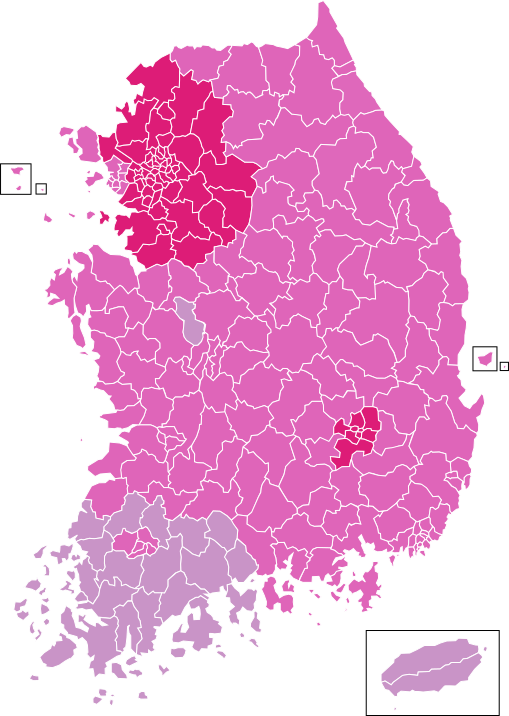

In [32]:
for item in glist:
    # svg파일에서 추출한 id값이 데이터프레임의 index에 속하지 않았다면 다음으로 넘어감
    if item['id'] not in 최종df.index:
        continue
    
    # item['id'] = 지도에서 뽑아낸 id = 지역명
    # 최종df에서 인덱스 이름이 지도에서 뽑아낸 id와 일치하는 행의 누적확진자 수 추출
    count = 최종df.loc[item['id'], '누적확진자']
    
    # 누적확진자 수에 따라 단계값 설정 (단계는 색상의 수에 따름)
    if count<30 : color_index=0
    elif count<100 : color_index=1
    elif count<1000 : color_index=2
    elif count<5000 : color_index=3
    else : color_index=4
        
    print("%s:확진자 수 : %d  // 색상인덱스: %d" % (item['id'], count, color_index))
    
    # item에 fill 속성이 있는 경우 -> 세종특별자치시
    if 'fill' in item.attrs:
        item['fill']=colors[color_index]
    #그렇지 않은 경우 -> 나머지 지역
    else:
        #현재요소(item)의 하위 항목들에 색상 적용
        for p in item.select('g, path'):
            if 'fill' in p.attrs:
                p['fill'] = colors[color_index]
                
지역별확진자svg = soup.prettify()

with open('지역별확진자.svg', 'w', encoding='utf-8') as f:
    f.write(지역별확진자svg)
    
SVG('지역별확진자.svg')